In [9]:
from pathlib import Path
import torch, pickle, gzip, math, os, time, shutil,matplotlib as mpl, matplotlib.pyplot as plt

#Get data

In [13]:
BASE_URL = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/"

TRAINING_IMAGES = "train-images-idx3-ubyte.gz"
TRAINING_LABELS = "train-labels-idx1-ubyte.gz"
TEST_IMAGES = "t10k-images-idx3-ubyte.gz"
TEST_LABELS = "t10k-labels-idx1-ubyte.gz"

In [14]:
PATH_DATA = Path("data")
PATH_DATA.mkdir(exist_ok=True)


training_images_path = PATH_DATA/TRAINING_IMAGES
training_labels_path = PATH_DATA/TRAINING_LABELS
test_images_path = PATH_DATA/TEST_IMAGES
test_labels_path = PATH_DATA/TEST_LABELS

In [15]:
from urllib.request import urlretrieve

In [16]:
if not training_images_path.exists():
  urlretrieve(BASE_URL+TRAINING_IMAGES, training_images_path)
if not training_labels_path.exists():
  urlretrieve(BASE_URL+TRAINING_LABELS, training_labels_path)
if not test_images_path.exists():
  urlretrieve(BASE_URL+TEST_IMAGES, test_images_path)
if not test_labels_path.exists():
  urlretrieve(BASE_URL+TEST_LABELS, test_labels_path)

In [17]:
import struct
import array
def parse_idx(path):
  with gzip.open(path, 'rb') as f:
    header = f.read(4)
    
    zeros, data_type, num_dimensions = struct.unpack('>HBB', header)
    dimension_sizes = struct.unpack('>' + 'I' * num_dimensions, f.read(4 * num_dimensions))
    

    data = array.array('B', f.read())
    data.byteswap()  # looks like array.array reads data as little endian

  return list(data)

def chunks(x, size):
    for i in range(0, len(x), size): 
        yield x[i:i + size]

In [19]:
x_train = list(chunks(parse_idx(training_images_path),784))
y_train = parse_idx(training_labels_path)

x_test = list(chunks(parse_idx(test_images_path),784))
y_test = parse_idx(test_labels_path)

print((len(x_train), len(x_train[0])))
print(len(y_train))

print((len(x_test), len(x_test[0])))
print(len(y_test))

(60000, 784)
60000
(10000, 784)
10000


In [20]:
from torch import tensor

In [96]:
x_train, y_train, x_test, y_test = map(lambda x: tensor(x, dtype=torch.float), (x_train, y_train, x_test, y_test))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


In [98]:
x_train.type()

'torch.FloatTensor'

In [94]:
def func1(a):
    return a**2

lst = [1, 2, 3]
print(list(map(func1, lst)))
#print(map(func1(x=4, y=3), lst))

[1, 4, 9]


# Random nubers

Based on the Wichmann Hill algorithm used before Python 2.3.

In [ ]:
rnd_state = None
def seed(a):
  global rnd_state
  a, x = divmod(a, 30268)
  a, y = divmod(a, 30306)
  a, z = divmod(a, 30322)
  rnd_state = int(x)+1, int(y)+1, int(z)+1

In [ ]:
seed(457428938475)
rnd_state

(4976, 20238, 499)

In [ ]:
def rand():
  global rnd_state
  x, y, z = rnd_state
  x = (171 * x) % 30269
  y = (172 * y) % 30307
  z = (170 * z) % 30323
  rnd_state = x,y,z
  return (x/30269 + y/30307 + z/30323) % 1.0

In [ ]:
rand(), rand(), rand()

(0.7645251082582081, 0.7920889799553945, 0.06912886811267205)

Issue with random number generation read [here](https://mlops.systems/computervision/fastai/parttwo/2022/10/24/foundations-mnist-basics.html#Generate-some-random-numbers) for more 

In [ ]:
if os.fork():
  print(f'Inparent: {rand()}')
else:
  print(f'In child: {rand()}')
  os._exit(os.EX_OK)

Inparent: 0.15532781424845843
In child: 0.15532781424845843


In [ ]:
if os.fork():
  print(f'Inparent: {torch.rand(1)}')
else:
  print(f'In child: {torch.rand(1)}')
  os._exit(os.EX_OK)


Inparent: tensor([0.1449])
In child: tensor([0.1449])


In [10]:
import numpy as np

In [ ]:
if os.fork():
  print(f'Inparent: {np.random.rand(1)}')
else:
  print(f'In child: {np.random.rand(1)}')
  os._exit(os.EX_OK)

Inparent: [0.15557271]
In child: [0.15557271]


In [ ]:
from random import random 

In [ ]:
if os.fork():
  print(f'Inparent: {random()}')
else:
  print(f'In child: {random()}')
  os._exit(os.EX_OK)

Inparent: 0.07139119726508514
In child: 0.11867943639224843


random numbers should have no correlation between them 

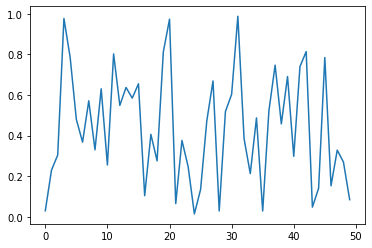

In [ ]:
plt.plot([rand() for _ in range(50)]);

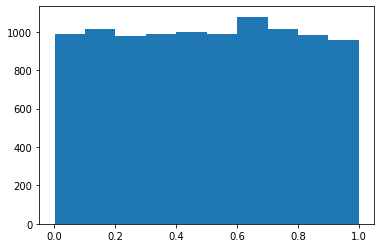

In [ ]:
plt.hist([rand() for _ in range(10000)]);

In [ ]:
print([i for i in range(10)])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [ ]:
%timeit -n 10 list(chunks([rand() for _ in range(7840)],10))

16.7 ms ± 4.04 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%timeit -n 10 torch.randn(784,10)

The slowest run took 16.73 times longer than the fastest. This could mean that an intermediate result is being cached.
409 µs ± 530 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# matrix multiplication

In [22]:
weights = torch.randn(784,10)
bias = torch.zeros(10)

In [99]:
m1 = x_test[:5]
m2 = weights

In [24]:
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [25]:
ar, ac = m1.shape
br, bc = m2.shape
(ar,ac), (br,bc)

((5, 784), (784, 10))

In [26]:
t1 = torch.zeros(ar, bc)
t1.shape

torch.Size([5, 10])

In [27]:
for i in range(ar):
  for j in range(bc):
    for k in range(ac):
      t1[i,j] += m1[i,k] * m2[k,j]

In [28]:
t1

tensor([[  752.1404,  -199.4974, -2760.0786, -1629.7404,  1425.1672, -1462.9799,
         -2943.9993,  1485.8739, -1623.0640, -1092.7344],
        [-1499.0490,  -654.4514,  -939.0584,  -853.6017,  4367.0371, -6446.9922,
         -2186.1750,  2657.9675, -6551.7695,  -652.3804],
        [ -985.9463,  -685.3962, -2754.8594,  2714.5679,  1202.4011, -3862.9167,
          4298.0303, -1560.0381, -2218.6030, -3341.4258],
        [ -504.8619, -2697.9363,  -734.5185,  1578.3490,  1276.0165, -3412.2544,
          1688.4396, -1793.0093, -2401.6067, -2518.4358],
        [-2418.3276,   405.3791,  1005.0917,  1529.8827,  2456.0583, -2184.4324,
          -903.9899,  1008.4126, -3656.0352,  1486.3264]])

In [29]:
t1.shape

torch.Size([5, 10])

To print on wider space 

In [31]:
import numpy as np

In [32]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
np.set_printoptions(precision=2, linewidth=140)
t1

tensor([[  752.14,  -199.50, -2760.08, -1629.74,  1425.17, -1462.98, -2944.00,  1485.87, -1623.06, -1092.73],
        [-1499.05,  -654.45,  -939.06,  -853.60,  4367.04, -6446.99, -2186.18,  2657.97, -6551.77,  -652.38],
        [ -985.95,  -685.40, -2754.86,  2714.57,  1202.40, -3862.92,  4298.03, -1560.04, -2218.60, -3341.43],
        [ -504.86, -2697.94,  -734.52,  1578.35,  1276.02, -3412.25,  1688.44, -1793.01, -2401.61, -2518.44],
        [-2418.33,   405.38,  1005.09,  1529.88,  2456.06, -2184.43,  -903.99,  1008.41, -3656.04,  1486.33]])

In [33]:
def matmul(a,b):
  (ar,ac),(br,bc) = a.shape, b.shape
  c = torch.zeros(ar,bc)
  for i in range(ar):
    for j in range(bc):
      for k in range(ac):
        c[i,j] += a[i,k] * b[k,j]


In [34]:
%time _=matmul(m1,m2)

CPU times: user 858 ms, sys: 1.35 ms, total: 860 ms
Wall time: 862 ms


#Numba
changes the python code to machine code
It goes fast when it runs for second time

In [35]:
from numba import njit

In [36]:
@njit
def dot(a,b):
  res = 0.
  for i in range (len(a)):
    res+=a[i]*b[i]
  return res

In [37]:
from numpy import array

In [38]:
%time dot(array([1.,2,3]),array([2.,3,4]))

CPU times: user 507 ms, sys: 61.5 ms, total: 568 ms
Wall time: 632 ms


20.0

Changing the third loop matmul function with with dot function defined above

In [39]:
def matmul(a,b):
  (ar,ac),(br,bc) = a.shape, b.shape
  c = torch.zeros(ar,bc)
  for i in range(ar):
    for j in range(bc):
      c[i,j] = dot(a[i,:],b[:,j])
  return c

In [40]:
m1a,m2a = m1.numpy(), m2.numpy() #changing the matrice to np array

In [45]:
from fastcore.test import *
test_close(t1,matmul(m1a, m2a), eps=1e-2) #checking if the two matrices are equal

In [46]:
%timeit -n 10 matmul(m1a,m2a)

564 µs ± 207 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


#Elementwise ops

In [71]:
def matmul(a,b):
  (ar,ac),(br,bc) = a.shape, b.shape
  c = torch.zeros(ar, bc)
  for i in range(ar):
    for j in range(bc):
      c[i,j] = (a[i,:] * b[:,j]).sum()
  return c

In [72]:
test_close(t1,matmul(m1, m2), eps=1e-2)

In [73]:
%timeit -n 10 _=matmul(m1, m2)

1.44 ms ± 230 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [74]:
def matmul(a,b):
  (ar,ac),(br,bc) = a.shape,b.shape
  c = torch.zeros(ar, bc)
  for i in range(ar):
    for j in range(bc):
      c[i,j] = torch.dot(a[i,:], b[:,j])
  return c

In [76]:
x_train.type()

'torch.LongTensor'

In [104]:
test_close(t1,matmul(m1, m2), eps=1e-2)

#Broadcasting

In [106]:
a = tensor([10., 6, -4])
b = tensor([2., 8, 7])
a,b

(tensor([10.,  6., -4.]), tensor([2., 8., 7.]))

In [108]:
a>0

tensor([ True,  True, False])

In [111]:
m = tensor([[1., 2, 3], [4,5,6], [7,8,9]]); m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [112]:
c = tensor([10.,20,30]); c

tensor([10., 20., 30.])

In [113]:
m.shape, c.shape

(torch.Size([3, 3]), torch.Size([3]))

In [117]:
m + c

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [119]:
t = c.expand_as(m)
t

tensor([[10., 20., 30.],
        [10., 20., 30.],
        [10., 20., 30.]])

In [120]:
m + t

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

We don't copy the rows

In [121]:
t.storage()

 10.0
 20.0
 30.0
[torch.storage._TypedStorage(dtype=torch.float32, device=cpu) of size 3]

You can index with the special value [None] or use unsqueeze() to convert a 1-dimensional array into a 2-dimensional array

In [134]:
 c.unsqueeze(0), c[None, :]

(tensor([[10., 20., 30.]]), tensor([[10., 20., 30.]]))

In [135]:
c.shape, c[None, :].shape

(torch.Size([3]), torch.Size([1, 3]))

In [139]:
 c[:,None]

tensor([[10.],
        [20.],
        [30.]])

In [140]:
 c[:,None].shape

torch.Size([3, 1])

In [141]:
c[None].shape, c[...,None].shape

(torch.Size([1, 3]), torch.Size([3, 1]))

In [143]:
c[:,None].expand_as(m)

tensor([[10., 10., 10.],
        [20., 20., 20.],
        [30., 30., 30.]])

In [142]:
m + c[:,None]

tensor([[11., 12., 13.],
        [24., 25., 26.],
        [37., 38., 39.]])

In [144]:
c[None,:] * c[:,None]

tensor([[100., 200., 300.],
        [200., 400., 600.],
        [300., 600., 900.]])

In [148]:
c[:,None] @ c[None,:] 

tensor([[100., 200., 300.],
        [200., 400., 600.],
        [300., 600., 900.]])

#Broadcasting rule

When operating on two arrays/tensors, Numpy/PyTorch compares their shapes element-wise. It starts with the trailing dimensions, and works its way forward. Two dimensions are compatible when



*  they are equal, or
*   one of them is 1, in which case that dimension is broadcasted to make it the same size




#matmul with broadcasting

In [150]:
cloth = m1[0]
cloth.shape, m2.shape

(torch.Size([784]), torch.Size([784, 10]))

In [151]:
cloth[:,None].shape

torch.Size([784, 1])

In [152]:
(cloth[:,None]*m2).shape

torch.Size([784, 10])

In [155]:
def matmul(a,b):
  (ar,ac),(br,bc) = a.shape, b.shape
  c = torch.zeros(ar,bc)
  for i in range(ar):
    c[i] = (a[i,:,None] * b).sum(dim=0)
  return c

In [159]:
test_close(t1,matmul(m1, m2), eps=1e-2)

In [160]:
%timeit -n 10 _=matmul(m1, m2)

299 µs ± 94.7 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [162]:
tr = matmul(x_train, weights)
tr

tensor([[ 2165.21, -1229.96, -1386.39,  ...,  5791.70, -5227.97,  -737.64],
        [-3796.37,  1353.31,  -285.88,  ...,  -862.43, -3184.57,  1069.33],
        [ -114.55,   308.63,   -26.12,  ..., -1164.44, -2484.93,  -361.99],
        ...,
        [   61.76,  -369.80, -2845.02,  ...,  -443.44, -2903.15,  1419.20],
        [ -710.85,  -157.07,   401.41,  ...,  -889.87, -1008.52,  -252.16],
        [  630.18,   636.72,  -393.60,  ...,  -275.03,   672.47,  2047.24]])

In [163]:
tr.shape

torch.Size([60000, 10])

In [164]:
%time _=matmul(x_train, weights)

CPU times: user 1.8 s, sys: 0 ns, total: 1.8 s
Wall time: 1.89 s
